## Import Packages

In [2]:
warnings.filterwarnings('ignore')

import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
print('Imports Complete')

OSError: dlopen(/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tensorflow/python/platform/../../core/platform/_cpu_feature_guard.so, 0x0006): tried: '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tensorflow/python/platform/../../core/platform/_cpu_feature_guard.so' (mach-o file, but is an incompatible architecture (have (arm64), need (x86_64))), '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tensorflow/core/platform/_cpu_feature_guard.so' (mach-o file, but is an incompatible architecture (have (arm64), need (x86_64)))

## Load Data

In [2]:
train = pd.read_csv('./data/LSTM-Multivariate_pollution.csv')
train.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [3]:
train.shape

(43800, 9)

In [4]:
train.index = pd.to_datetime(train['date'], format='%Y.%m.%d %H:%M:%S')

## Section off target 

<AxesSubplot:xlabel='date'>

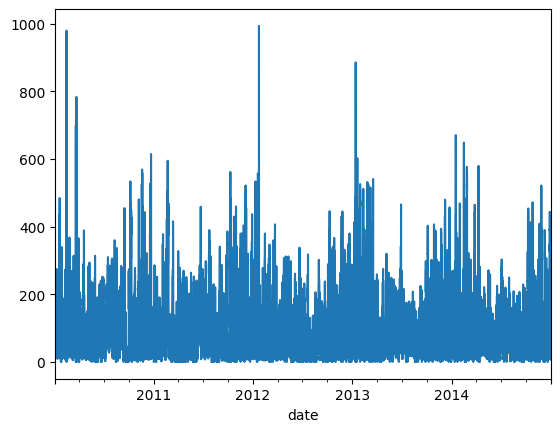

In [5]:
poll = train['pollution']
poll.plot()

In [6]:
train.wnd_dir.unique()

array(['SE', 'cv', 'NW', 'NE'], dtype=object)

### Encode the wind direction

In [7]:
def wind_encode(s):
    if s == "SE":
        return 1
    elif s == "NE":
        return 2
    elif s == "NW":
        return 3
    else:
        return 4

train["wind_dir"] = train["wnd_dir"].apply(wind_encode)
train = train.drop(["wnd_dir", 'date'], axis=1).head()
train.head()

,pollution,dew,temp,press,wnd_spd,snow,rain,wind_dir
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,1
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,1
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,1
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,1
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,1


## Split the dataframe into X and y

In [8]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+5]]
        X.append(row)
        label = df_as_np[i+5]
        y.append(label)
    return np.array(X), np.array(y)

In [9]:
WINDOW_SIZE=5
X, y = df_to_X_y(poll, WINDOW_SIZE)
X.shape, y.shape

((43795, 5, 1), (43795,))

In [10]:
X_train, y_train = X[:35000], y[:35000]
X_val, y_val = X[35000:], y[35000:65000]

## Create a basic LSTM model

In [11]:
model1 = Sequential()
model1.add(InputLayer((5,1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


### Create a checkpoint and compile

In [14]:
cp = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss='mse', optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [15]:
model1.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=10, verbose=1, callbacks=[cp])

Epoch 1/10


2023-03-09 10:42:46.613668: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1060/1094 [============================>.] - ETA: 0s - loss: 16333.6621 - root_mean_squared_error: 127.8032

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1094/1094 [==============================] - 5s 4ms/step - loss: 16214.4951 - root_mean_squared_error: 127.3362 - val_loss: 15316.8467 - val_root_mean_squared_error: 123.7612
Epoch 2/10
1076/1094 [============================>.] - ETA: 0s - loss: 13025.2646 - root_mean_squared_error: 114.1283

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1094/1094 [==============================] - 4s 4ms/step - loss: 13002.0830 - root_mean_squared_error: 114.0267 - val_loss: 12137.2363 - val_root_mean_squared_error: 110.1691
Epoch 3/10
1054/1094 [===========================>..] - ETA: 0s - loss: 10094.8369 - root_mean_squared_error: 100.4731

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1094/1094 [==============================] - 4s 4ms/step - loss: 10033.6338 - root_mean_squared_error: 100.1680 - val_loss: 9246.6475 - val_root_mean_squared_error: 96.1595
Epoch 4/10
1055/1094 [===========================>..] - ETA: 0s - loss: 7455.2339 - root_mean_squared_error: 86.3437

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1094/1094 [==============================] - 4s 4ms/step - loss: 7467.2969 - root_mean_squared_error: 86.4135 - val_loss: 6855.0420 - val_root_mean_squared_error: 82.7952
Epoch 5/10
1060/1094 [============================>.] - ETA: 0s - loss: 5501.6118 - root_mean_squared_error: 74.1729

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1094/1094 [==============================] - 4s 4ms/step - loss: 5459.2886 - root_mean_squared_error: 73.8870 - val_loss: 5066.8604 - val_root_mean_squared_error: 71.1819
Epoch 6/10
1086/1094 [============================>.] - ETA: 0s - loss: 4001.9382 - root_mean_squared_error: 63.2609

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1094/1094 [==============================] - 4s 4ms/step - loss: 3992.3113 - root_mean_squared_error: 63.1847 - val_loss: 3751.7795 - val_root_mean_squared_error: 61.2518
Epoch 7/10
1090/1094 [============================>.] - ETA: 0s - loss: 2942.9265 - root_mean_squared_error: 54.2487

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1094/1094 [==============================] - 4s 4ms/step - loss: 2946.6111 - root_mean_squared_error: 54.2827 - val_loss: 2795.0635 - val_root_mean_squared_error: 52.8684
Epoch 8/10
1055/1094 [===========================>..] - ETA: 0s - loss: 2206.1912 - root_mean_squared_error: 46.9701

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1094/1094 [==============================] - 4s 4ms/step - loss: 2224.6267 - root_mean_squared_error: 47.1659 - val_loss: 2104.0823 - val_root_mean_squared_error: 45.8703
Epoch 9/10
1083/1094 [============================>.] - ETA: 0s - loss: 1740.3047 - root_mean_squared_error: 41.7170

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1094/1094 [==============================] - 4s 4ms/step - loss: 1737.7471 - root_mean_squared_error: 41.6863 - val_loss: 1614.1957 - val_root_mean_squared_error: 40.1771
Epoch 10/10
1062/1094 [============================>.] - ETA: 0s - loss: 1420.6798 - root_mean_squared_error: 37.6919

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets



1094/1094 [==============================] - 4s 4ms/step - loss: 1411.8401 - root_mean_squared_error: 37.5745 - val_loss: 1275.0240 - val_root_mean_squared_error: 35.7075


## Predictions vs Actual Training data

In [16]:
model1 = load_model('model1/')
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions': train_predictions,
                                  'Actual':y_train})
train_results.head()

1094/1094 [==============================] - 1s 479us/step


,Train Predictions,Actual
0,115.109421,109.0
1,95.844048,105.0
2,100.993172,124.0
3,126.586044,120.0
4,115.648369,132.0


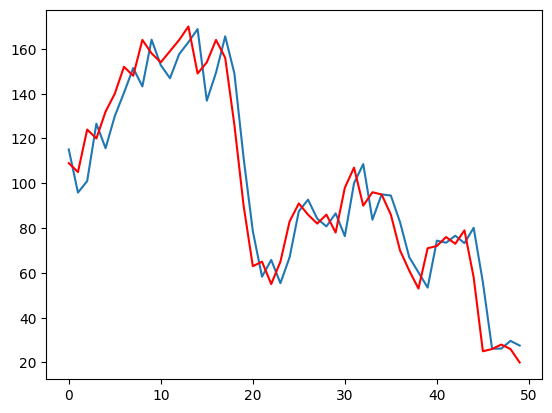

In [17]:
plt.plot(train_results['Train Predictions'][:50])
plt.plot(train_results['Actual'][:50], c='r');

In [18]:
train_rmse = np.sqrt(mse(y_train, train_predictions))
print("Validation RMSE =",train_rmse)

Validation RMSE = 35.890898449826786


## Predictions vs Actual Validation data

In [19]:
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions': val_predictions,
                                  'Actual':y_val})
val_results.head()

275/275 [==============================] - 0s 521us/step


,Val Predictions,Actual
0,42.296715,27.0
1,25.569708,25.0
2,23.924700,25.0
3,26.366285,25.0
4,26.383265,25.0


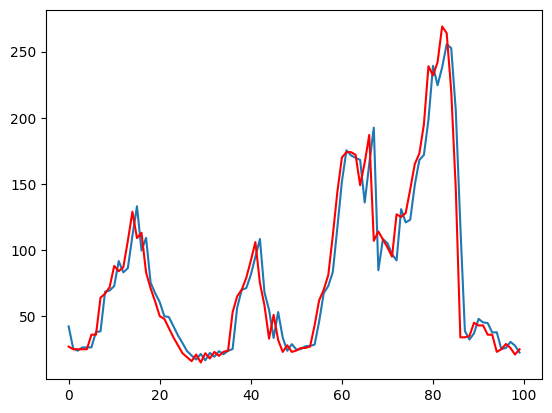

In [20]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actual'][:100], c='r')

In [21]:
rmse = np.sqrt(mse(y_val, val_predictions))
print("Validation RMSE ="  ,rmse)

Validation RMSE = 35.70747672299631


## Try on given test data

In [22]:
test = pd.read_csv('./data/pollution_test_data1.csv')
test.head()

,dew,temp,press,wnd_dir,wnd_spd,snow,rain,pollution
0,-16,4,1027,SE,3.58,0,0,128
1,-17,5,1027,SE,7.60,0,0,77
2,-16,4,1027,SE,9.39,0,0,65
3,-16,1,1028,cv,0.89,0,0,79
4,-14,0,1028,NE,1.79,0,0,93


<AxesSubplot:>

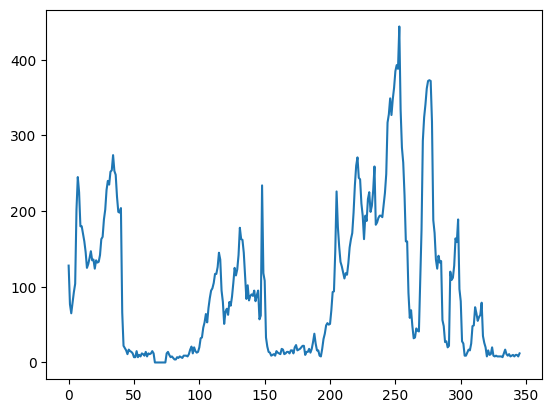

In [23]:
target2 = test['pollution']
target2.plot()

In [24]:
def wind_encode(s):
    if s == "SE":
        return 1
    elif s == "NE":
        return 2
    elif s == "NW":
        return 3
    else:
        return 4

test["wind_dir"] = test["wnd_dir"].apply(wind_encode)
test = test.drop(["wnd_dir"], axis=1).head()
test.head()

,dew,temp,press,wnd_spd,snow,rain,pollution,wind_dir
0,-16,4,1027,3.58,0,0,128,1
1,-17,5,1027,7.60,0,0,77,1
2,-16,4,1027,9.39,0,0,65,1
3,-16,1,1028,0.89,0,0,79,4
4,-14,0,1028,1.79,0,0,93,2


In [25]:
WINDOW_SIZE=5
X_test, y_test = df_to_X_y(target2, WINDOW_SIZE)
X_test.shape, y_test.shape

((341, 5, 1), (341,))

In [26]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions,
                                  'Actual':y_test})
test_results.head()

11/11 [==============================] - 0s 784us/step


,Test Predictions,Actual
0,95.916191,104
1,105.255920,202
2,201.844894,245
3,238.131287,225
4,214.194504,180


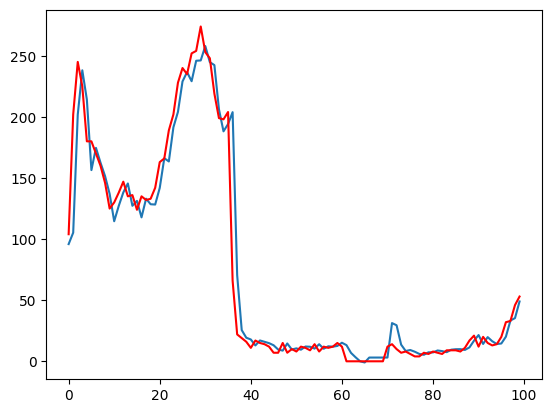

In [27]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actual'][:100], c='r')

In [28]:
rmse = np.sqrt(mse(y_test, test_predictions))
print("Validation RMSE =",rmse)

Validation RMSE = 32.4171546809721


In [29]:
target2.head()

0    128
1     77
2     65
3     79
4     93
Name: pollution, dtype: int64

In [30]:
def plot_predictions1(model, X, y, start=0, end=100):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions':predictions,
                           'Actual': y})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actual'][start:end], c='r')
    return df, np.sqrt(mse(y, predictions))

11/11 [==============================] - 0s 813us/step


(     Predictions  Actual
 0      95.916191     104
 1     105.255920     202
 2     201.844894     245
 3     238.131287     225
 4     214.194504     180
 ..           ...     ...
 336    10.750286       8
 337     9.466482      10
 338    10.630943      10
 339    10.876947       8
 340     9.502650      12
 
 [341 rows x 2 columns],
 32.4171546809721)

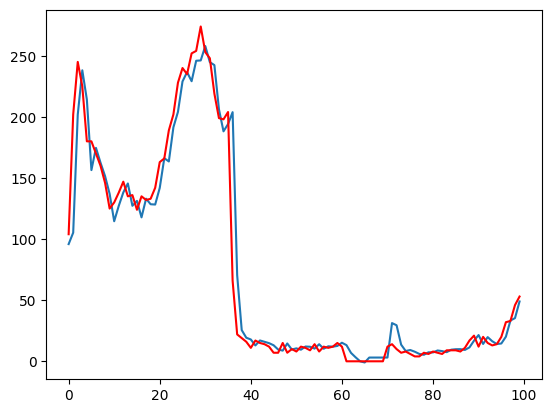

In [31]:
plot_predictions1(model1, X_test, y_test)

In [62]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Val Predictions': test_predictions,
                                  'Actual':y_test})
test_results.head()

11/11 [==============================] - 0s 977us/step


,Val Predictions,Actual
0,95.916191,104
1,105.255920,202
2,201.844894,245
3,238.131287,225
4,214.194504,180


In [67]:
test_rmse = np.sqrt(mse(y_test, test_predictions))
print("Validation RMSE =",round(train_rmse, 4))

Validation RMSE = 35.8909


## Create a very simple model using Conv1D


In [61]:
# model2 = Sequential()
# model2.add(InputLayer((5,1)))
# model2.add(Conv1D(64, kernel_size=2)) 
# model2.add(Flatten())
# model2.add(Dense(8, 'relu'))
# model2.add(Dense(1, 'linear'))

# model2.summary()

In [58]:
# cp2 = ModelCheckpoint('model2/', save_best_only=True)
# model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [59]:
# model2.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=10, verbose=1, callbacks=[cp2])

11/11 [==============================] - 0s 941us/step


(     Predictions  Actual
 0      95.916191     104
 1     105.255920     202
 2     201.844894     245
 3     238.131287     225
 4     214.194504     180
 ..           ...     ...
 336    10.750286       8
 337     9.466482      10
 338    10.630943      10
 339    10.876947       8
 340     9.502650      12
 
 [341 rows x 2 columns],
 32.4171546809721)

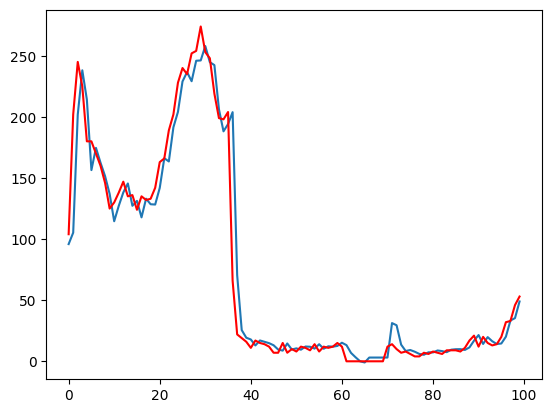

In [60]:
# plot_predictions1(model1, X_test, y_test)

In [64]:
# test_predictions = model1.predict(X_test).flatten()
# test_results = pd.DataFrame(data={'Val Predictions': test_predictions,
#                                   'Actual':y_test})
# test_results.head()

In [63]:
# test_rmse = np.sqrt(mse(y_test, test_predictions))
# print("Validation RMSE =",train_rmse)